In [1]:
# 1/29/2022
# markstro
#
# This notebook demos: (1) swrad with ddsolrad method

In [2]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import math

In [3]:
pfn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/hru1.params"
outdir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/output/"
indir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/"
soltab_fn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/soltab_sunhrs.csv"

In [4]:
# Constants
NORTHERN = 1
SOUTHERN = 2

solf = np.array([.20, .35, .45, .51, .56, .59, .62, .64, .655, .67, .682, .69, .70, .71,
                 .715, .72, .722, .724, .726, .728, .73, .734, .738, .742, .746, .75])

# Utility functions

In [5]:
# Function that will read PRMS parameter file
# Returns the contents of param file in python data structures
def read_param_file(pfn):
    line_num = 0
    vals = {}
    dims = {}
    param_dims = {}
    param_type = {}

    with open(pfn) as f:
        reading_dims = False
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1
                if line == '** Dimensions **':
                    reading_dims = True
                    line = f.readline().rstrip() 
                    line_num += 1

                if line == '** Parameters **':
                    reading_dims = False
                    break

                if reading_dims:
                    line = f.readline().rstrip()
                    line_num += 1
                    dim_name = line
                    
                    line = f.readline().rstrip() 
                    line_num += 1
                    size = line
                    
                    if dim_name in dims.keys():
                        pass
                    else:
                        dims[dim_name] = int(size)
            except:
                print("**** read parameters exception line = ", line)
                print("**** read parameters exception line_num = ", str(line_num))
                print("**** Unexpected error:", sys.exc_info()[0])

#        read params
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1

                if line == "####":
                    line = f.readline().rstrip()
                    line = line.split(' ', 1)[0]  # old format parameter files have a blank (' ') and then a width format value. Strip this off.
                    param_name = line
                    line_num += 1

                    line = f.readline().rstrip()
                    line_num += 1
                    num_dims = int(line)
                    pd = [None] * num_dims
                    for ii in range(num_dims):
                        line = f.readline().rstrip()
                        pd[ii] = line
                        line_num += 1

                    param_dims[param_name] = pd

                    line = f.readline().rstrip()
                    line_num += 1
                    num_vals = int(line)
                    line = f.readline().rstrip()
                    line_num += 1
                    tp = int(line)
                    param_type[param_name] = tp

                    if tp == 2:
                        vs = np.zeros(num_vals, dtype=np.float)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = float(line)

                    elif tp == 1:
                        vs = np.zeros(num_vals, dtype=np.int)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = int(line)

                    else:
                        vs = np.zeros(num_vals, dtype=np.chararray)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = line

                    if num_dims == 2:
                        vs.shape = (dims[pd[1]], dims[pd[0]])

                    if param_name in vals.keys():
                        print("parameter ", param_name, " is already in ", pfn)
                    else:
                        vals[param_name] = vs

            except:
                print("read parameters exception line_num = ", str(line_num))
                print("Unexpected error:", sys.exc_info()[0])
                
    gc.collect()
    
    return (dims, vals, param_dims, param_type)

In [6]:
# I don't understand why I needed to write this function myself
# Input: datetime.Date
# Output: day of the year (aka "Julian date")
def day_of_year(d):
    N1 = math.floor(275 * d.month / 9)
    N2 = math.floor((d.month + 9) / 12)
    N3 = (1 + math.floor((d.year - 4 * math.floor(d.year / 4) + 2) / 3))
    N = N1 - (N2 * N3) + d.day - 30
    return N

In [7]:
def which_hemisphere(hl, ha):
    basin_lat = sum(hl * ha) / sum(ha)
    if basin_lat > 0.0:
        return NORTHERN
    else:
        return SOUTHERN

def is_summer(jday, hemi):
    if hemi == NORTHERN:
        if jday < 79 or jday > 265:
            return False
    else:
        if jday < 79 and jday > 265:
            return False
        
    return True

# Read the simulated output into a dataframe

In [8]:
# This loops over all of the csv files in the output directory

sim_vals = None
for filename in os.listdir(outdir):
    f = os.path.join(outdir,filename)
    if os.path.isfile(f) and f.endswith('.csv'):
        varname = filename.split('.')[0]
        
        if sim_vals is None:
            sim_vals = pd.read_csv(f, names=["datestr", varname], skiprows=1)
            
        else:
            if varname != 'stats':
                df = pd.read_csv(f, names=["datestr", varname], skiprows=1)
                sim_vals = pd.merge(sim_vals, df[["datestr", varname]], on="datestr", how="left")

sim_vals["date"] = [datetime.strptime(date, '%Y-%m-%d').date() for date in sim_vals["datestr"]]
del sim_vals['datestr']

In [9]:
sim_vals.head()

,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
0,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.1863,0.0000,403.8735,78.5987,9.8522,49.7339,1,1980-10-01
1,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,0.1030,0.1030,0.0,0.1840,0.0566,396.4248,77.5987,10.8522,51.5339,1,1980-10-02
2,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,0.2629,0.2629,0.0,0.1359,0.2017,319.9297,66.2987,10.6300,51.1339,1,1980-10-03
3,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,0.0672,0.0672,0.0,0.1282,0.2280,316.8498,66.2987,7.2411,45.0339,1,1980-10-04
4,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.1083,0.2147,279.8678,63.0987,6.0744,42.9339,1,1980-10-05


In [10]:
sim_vals.tail()

,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
360,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0559,0.6204,145.3992,66.1987,10.4633,50.8339,1,1981-09-26
361,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.1527,0.5382,360.0937,77.4987,11.4633,52.6339,1,1981-09-27
362,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.0864,0.5142,233.4196,69.1987,6.2411,43.2339,1,1981-09-28
363,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0437,0.5026,131.8481,59.0987,4.6855,40.4339,1,1981-09-29
364,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.0438,0.4990,130.6410,61.7987,3.8522,38.9339,1,1981-09-30


# Read the CBH forcing data into the dataframe

In [11]:
def add_date_for_PRMS_dates(df):
    df["date"] = [date(y, m, d) for y, m, d in zip(df["yr"], df["mo"], df["da"])]
    del df["yr"]
    del df["mo"]
    del df["da"]
    del df["hr"]
    del df["mi"]
    del df["se"]
    return df

In [12]:
# Read the CBH forcing inputs
cbh_vals = None
for filename in os.listdir(indir):
    f = os.path.join(indir,filename)
    if os.path.isfile(f) and f.endswith('.cbh'):
        varname = filename.split('.')[0]
        
        if cbh_vals is None:
            cbh_vals = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            cbh_vals = add_date_for_PRMS_dates(cbh_vals)

        else:
            foo = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            foo = add_date_for_PRMS_dates(foo)
            cbh_vals = pd.merge(cbh_vals, foo[["date", varname]], on="date", how="left")

In [13]:
cbh_vals.head()

,prcp,date,tmax,tmin
0,0.00,1979-01-01,43.6,31.0
1,0.04,1979-01-02,47.2,31.0
2,0.02,1979-01-03,53.0,34.1
3,0.49,1979-01-04,53.7,38.2
4,0.48,1979-01-05,42.9,34.9


In [14]:
cbh_vals.tail()

,prcp,date,tmax,tmin
14977,0.00,2019-12-27,50.6,34.2
14978,0.00,2019-12-28,48.3,29.1
14979,0.76,2019-12-29,41.8,29.6
14980,0.82,2019-12-30,39.6,34.6
14981,0.11,2019-12-31,43.8,35.3


In [15]:
# Read the solrad file that comes from running when print_debug is set to 5 in the control file.
# These are the values produced by the soltab module in PRMS
# They are produced by the python function "compute_soltab" in notebook CBH_to_solar_table.ipynb
#
# I read them from the PRMS output (as opposed to using the python computed values) to insure
# that the computed swrad values are as close as possible to the output coming from PRMS. The
# solar table calculations have a lot of trig functions and are suspetable to round off errors
# that are noticable at the .001 level. Just avoid that by reading in the PRMS computed solar
# table to pass subsequent tests.

In [16]:
soltab_vals = pd.read_csv(soltab_fn)

In [17]:
soltab_vals.head()

,jday,soltab_sunhrs,soltab_potsw
0,1,8.978,324.590
1,2,8.990,325.899
2,3,9.003,327.330
3,4,9.017,328.884
4,5,9.032,330.560


# Sync up the dates of the forcings and the outputs. This makes sure that all values are compared for the same date(s)

In [18]:
synced_vals = pd.merge(cbh_vals, sim_vals, on="date", how="right")

In [19]:
print(synced_vals.shape)

(365, 20)


In [20]:
synced_vals.head()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
0,0.00,1980-10-01,77.5,50.1,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.1863,0.0000,403.8735,78.5987,9.8522,49.7339,1
1,0.17,1980-10-02,76.5,51.9,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,0.1030,0.1030,0.0,0.1840,0.0566,396.4248,77.5987,10.8522,51.5339,1
2,0.43,1980-10-03,65.2,51.5,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,0.2629,0.2629,0.0,0.1359,0.2017,319.9297,66.2987,10.6300,51.1339,1
3,0.11,1980-10-04,65.2,45.4,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,0.0672,0.0672,0.0,0.1282,0.2280,316.8498,66.2987,7.2411,45.0339,1
4,0.00,1980-10-05,62.0,43.3,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.1083,0.2147,279.8678,63.0987,6.0744,42.9339,1


In [21]:
synced_vals.tail()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
360,0.00,1981-09-26,65.1,51.2,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0559,0.6204,145.3992,66.1987,10.4633,50.8339,1
361,0.02,1981-09-27,76.4,53.0,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.1527,0.5382,360.0937,77.4987,11.4633,52.6339,1
362,0.00,1981-09-28,68.1,43.6,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.0864,0.5142,233.4196,69.1987,6.2411,43.2339,1
363,0.00,1981-09-29,58.0,40.8,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0437,0.5026,131.8481,59.0987,4.6855,40.4339,1
364,0.02,1981-09-30,60.7,39.3,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.0438,0.4990,130.6410,61.7987,3.8522,38.9339,1


In [22]:
# ddsolrad run code:
def ddsolrad_run(dates, tmax_hru, hru_ppt, soltab_potsw, radadj_intcp, radadj_slope, tmax_index, dday_slope,
                     dday_intcp, radmax, hru_slope, ppt_rad_adj, radj_sppt, radj_wppt, tmax_allrain,
                     hemisphere):

    swrad = np.zeros(len(dates))
    
    ihru = 0
    hru_cossl = math.cos(math.atan(hru_slope[ihru]))

    ii = 0
    for date in dates:
        jday = day_of_year(date)
        imon = date.month - 1

# ! set degree day and radiation adjustment limited by radmax
        dday = dday_slope[imon, ihru] * tmax_hru[ii] + dday_intcp[imon, ihru] + 1.0
        if dday < 1.0:
            dday = 1.0
            
        if dday < 26.0:
            kp = int(dday)
            ddayi = float(kp)
            kp1 = kp + 1
            radadj = solf[kp-1] + ((solf[kp1-1] - solf[kp-1]) * (dday - ddayi))
            if radadj > radmax[imon, ihru]:
                radadj = radmax[imon, ihru]
        else:
            radadj = radmax[imon, ihru]
        
#           ! Set precipitation adjument factor based on temperature
#           ! and amount of precipitation

        pptadj = 1.0
        if hru_ppt[ii] > ppt_rad_adj[imon, ihru]:
            if tmax_hru[ii] < tmax_index[imon, ihru]:
                pptadj = radj_sppt[ihru]
                if tmax_hru[ii] >= tmax_allrain[imon]:
                    if not is_summer(jday, hemisphere):
                        pptadj = radj_wppt[ihru]
                else:
                    pptadj = radj_wppt[ihru]
            else:
                pptadj = radadj_intcp[imon,ihru] + radadj_slope[imon,ihru] * (
                    tmax_hru[ii] - tmax_index[imon, ihru])
                if pptadj > 1.0:
                    pptadj = 1.0
                    
        radadj = radadj * pptadj
        if radadj < 0.2:
            radadj = 0.2
                    
        swrad[ii] = soltab_potsw[jday-1] * radadj / hru_cossl
        ii += 1
        
    return swrad
    

In [23]:
dates = synced_vals["date"].values
# tmax_hru are adjusted by tmax_cbh_adj and are saved out as tmaxf.csv
tmax_hru = synced_vals["tmaxf"].values
hru_ppt = synced_vals["hru_ppt"].values

soltab_potsw = soltab_vals["soltab_potsw"].values

params = read_param_file(pfn)
vals = params[1]
radadj_intcp = vals["radadj_intcp"]
radadj_slope = vals["radadj_slope"]
tmax_index = vals["tmax_index"]
dday_slope = vals["dday_slope"]
dday_intcp = vals["dday_intcp"]
radmax = vals["radmax"]
hru_slope = vals["hru_slope"]
ppt_rad_adj = vals["ppt_rad_adj"]
radj_sppt = vals["radj_sppt"]
radj_wppt = vals["radj_wppt"]
tmax_allsnow = vals["tmax_allsnow"]
tmax_allrain_offset = vals["tmax_allrain_offset"]
tmax_allrain = tmax_allsnow + tmax_allrain_offset
hru_lat = vals["hru_lat"]
hru_area = vals["hru_area"]

hemisphere = which_hemisphere(hru_lat, hru_area)


swrad = ddsolrad_run(dates, tmax_hru, hru_ppt, soltab_potsw, radadj_intcp, radadj_slope, tmax_index, dday_slope,
                     dday_intcp, radmax, hru_slope, ppt_rad_adj, radj_sppt, radj_wppt, tmax_allrain,
                     hemisphere)

In [24]:
dates = synced_vals["date"].values

In [25]:
err = synced_vals["swrad"].values - swrad
print(sum(synced_vals["swrad"].values), sum(swrad))

105497.4897 105497.46293089048


Text(0, 0.5, 'Error swrad (Langleys per day)')

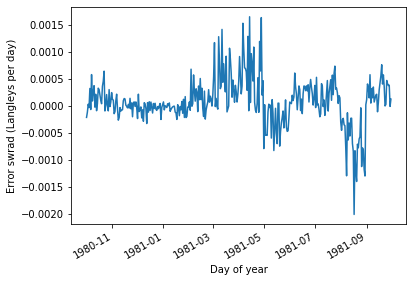

In [26]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Error swrad (Langleys per day)")

In [27]:
rerr = err / synced_vals["swrad"].values

Text(0, 0.5, 'Relative Error swrad (Unitless)')

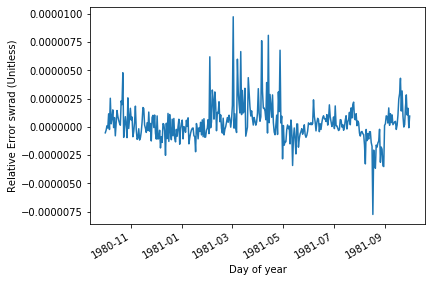

In [28]:
plt.plot(dates, rerr)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Relative Error swrad (Unitless)")

Text(0, 0.5, 'Python computed swrad (Langleys per day)')

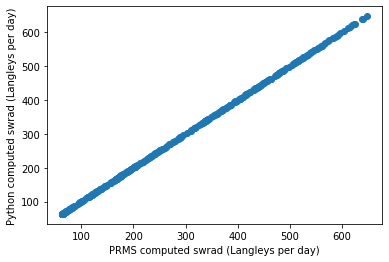

In [29]:
plt.scatter(synced_vals["swrad"].values, swrad)
plt.xlabel("PRMS computed swrad (Langleys per day)")
plt.ylabel("Python computed swrad (Langleys per day)")